Plotting for width=0.1


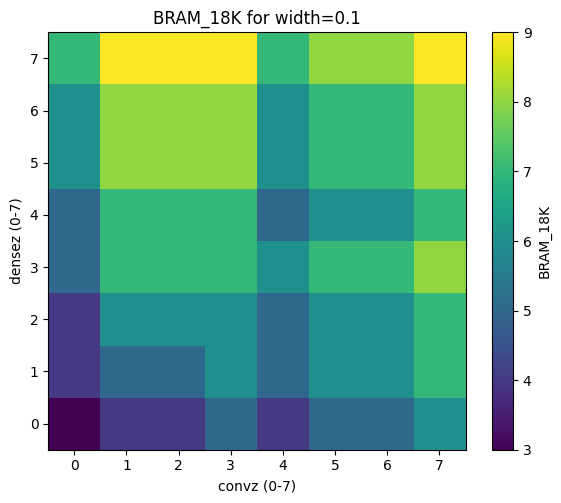

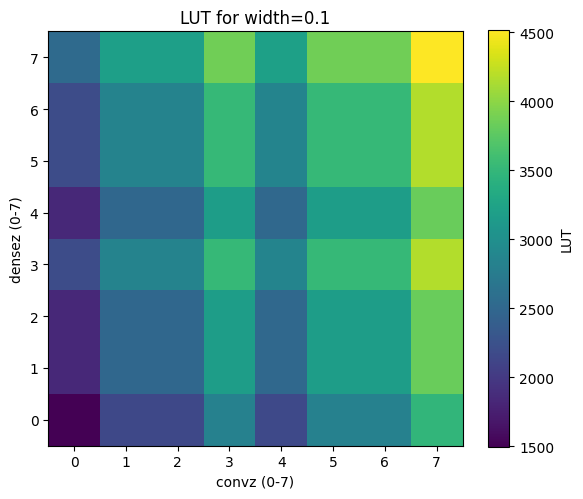

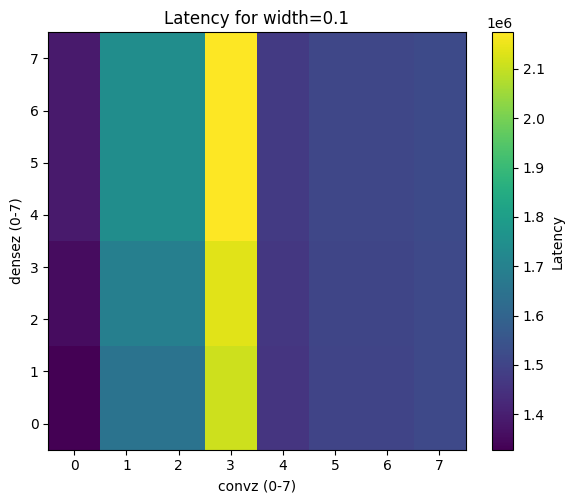

Plotting for width=0.2


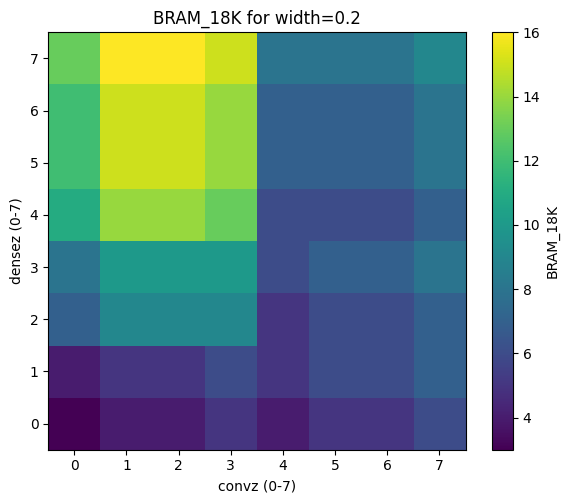

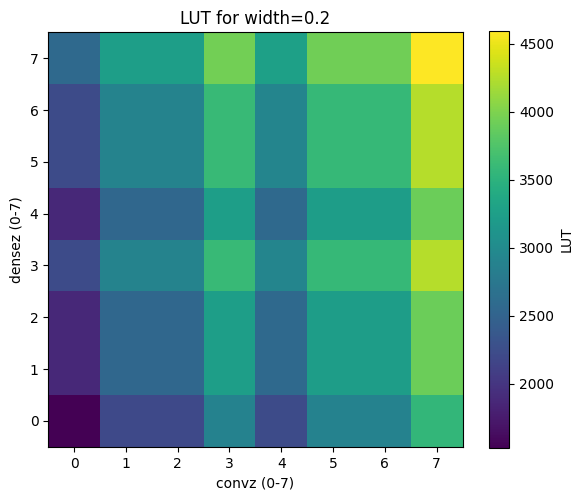

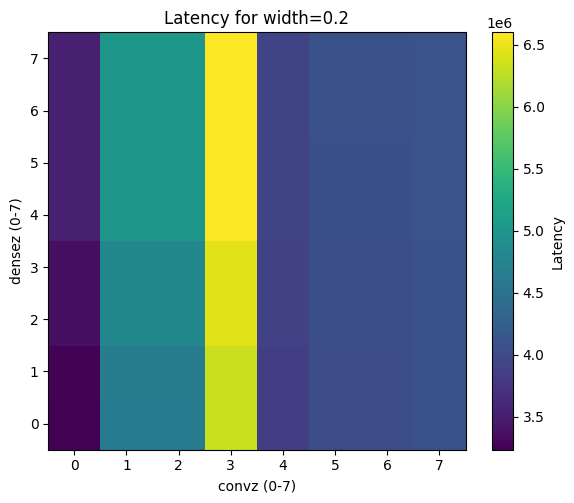

Plotting for width=0.3


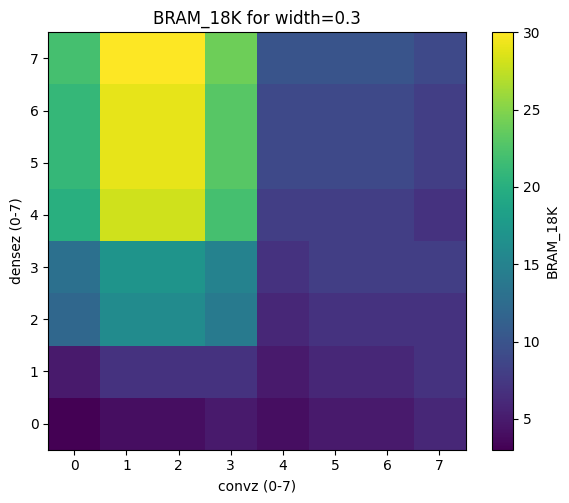

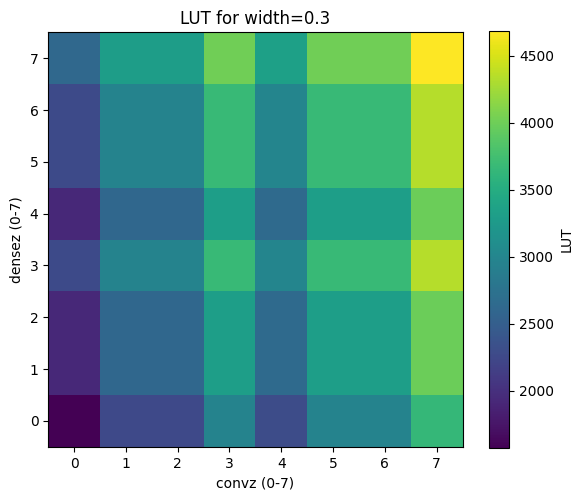

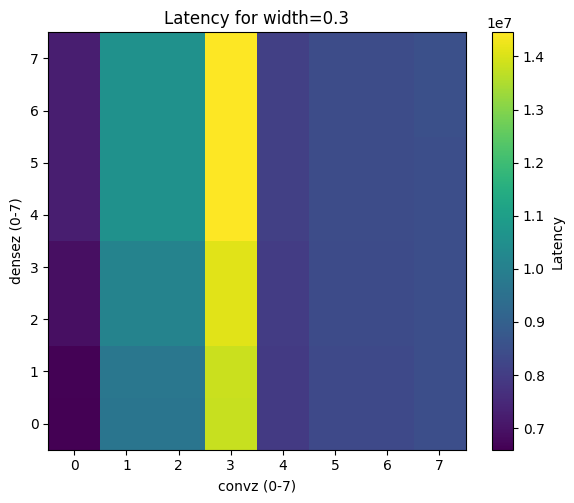

Plotting for width=0.4


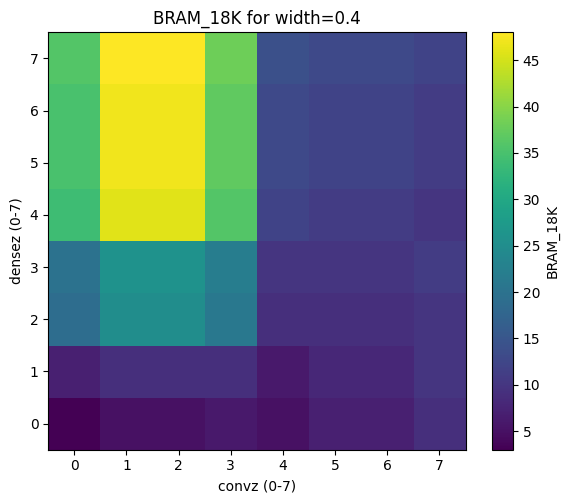

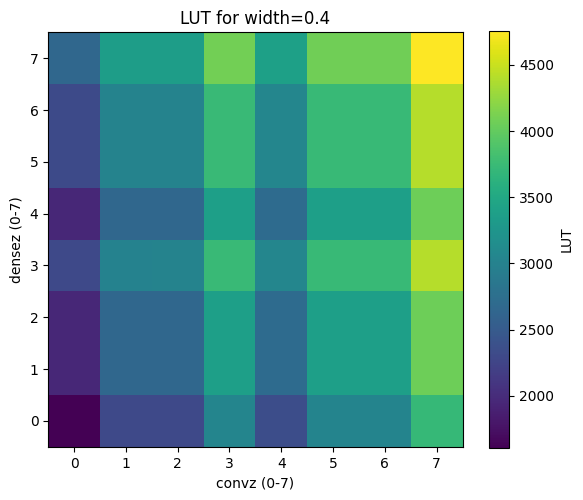

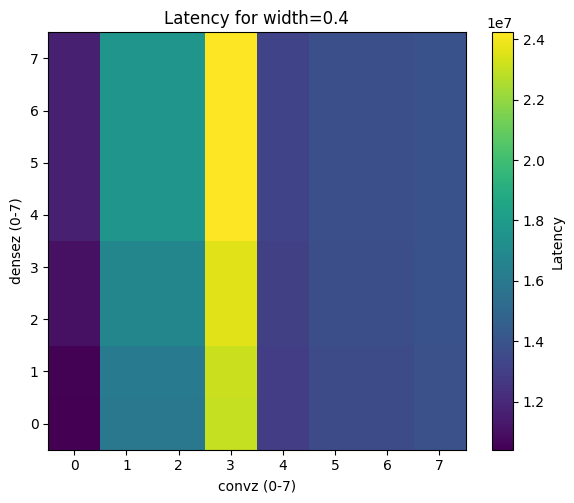

Plotting for width=0.5


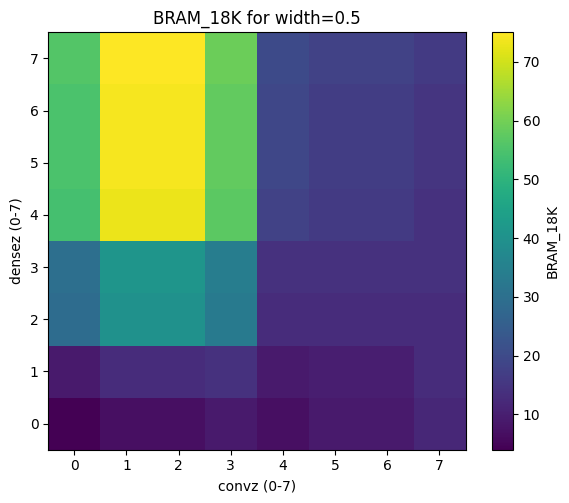

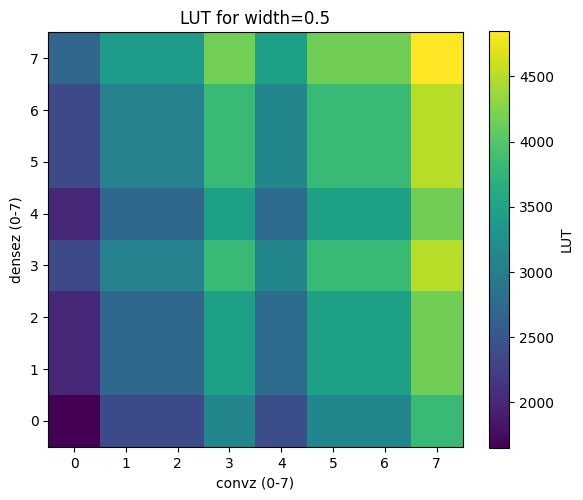

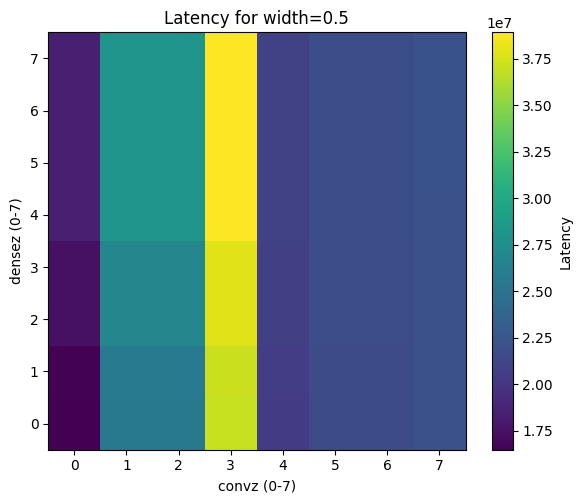

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

# Folder where your files are
folder = './projects/layer_stats_complx_bn_70x70'

# Data storage: width → (conv_idx, dense_idx) → (bram, lut, latency)
data = {}

width_multipliers = [0.1 * i for i in range(1, 6)]  # [0.1, 0.2, ..., 0.5]
for width in width_multipliers:
    data[np.round(width, 1)] = {}

# Load all data
for file_name in os.listdir(folder):
    if file_name.endswith('.json') and not file_name.endswith('.perf.json'):
        base_name = file_name[:-5]

        json_path = os.path.join(folder, f"{base_name}.json")
        perf_path = os.path.join(folder, f"{base_name}.perf.json")

        if not os.path.exists(json_path) or not os.path.exists(perf_path):
            continue

        try:
            parts = base_name.split('.')
            width = float(f"{parts[0]}.{parts[1]}")
            convz = parts[2]
            densez = parts[3]
            conv_idx = int(convz, 2)
            dense_idx = int(densez, 2)
        except Exception as e:
            print(f"Skipping {base_name} due to error: {e}")
            continue

        # Read json
        with open(json_path, 'r') as f:
            json_data = json.load(f)
            bram = json_data['total']['BRAM_18K']
            lut = json_data['total']['LUT']

        with open(perf_path, 'r') as f:
            perf_data = json.load(f)
            latency = perf_data['estimated_latency_ns']

        data[np.round(width, 1)][(conv_idx, dense_idx)] = (bram, lut, latency)

# --- Now plotting ---
metrics = ['BRAM_18K', 'LUT', 'Latency']

for width in width_multipliers:
    width = np.round(width, 1)
    print(f"Plotting for width={width}")

    # Prepare arrays
    heatmaps = {
        'BRAM_18K': np.full((8, 8), np.nan),
        'LUT': np.full((8, 8), np.nan),
        'Latency': np.full((8, 8), np.nan)
    }

    # Fill heatmaps
    for (conv_idx, dense_idx), (bram, lut, latency) in data[width].items():
        heatmaps['BRAM_18K'][dense_idx, conv_idx] = bram
        heatmaps['LUT'][dense_idx, conv_idx] = lut
        heatmaps['Latency'][dense_idx, conv_idx] = latency

    # Create 3 separate plots
    for metric in metrics:
        plt.figure(figsize=(6,5))
        plt.title(f'{metric} for width={width}')
        plt.xlabel('convz (0-7)')
        plt.ylabel('densez (0-7)')
        plt.xticks(np.arange(8))
        plt.yticks(np.arange(8))
        im = plt.imshow(heatmaps[metric], origin='lower', cmap='viridis')
        plt.colorbar(im, label=metric)
        plt.grid(False)
        plt.tight_layout()
        plt.show()